Note:  For now the code cells must be opened for the dropdown lists to work correctly.

In [34]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Clean Water Act Historic Compliance Violations

This notebook examines ECHO data using NPDES_QNCR_HISTORY, 
which reports the number of non-compliance violations in
four categories:
1) Effluent (E90) violations
2) Compliance schedule violagions,
3) Single event violations
4) Permit schedule violations

A state and congressional district must be chosen.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

column_mapping = {
    "REGISTRY_ID": str,
    "FAC_NAME": str,
    "FAC_ZIP": str,
    "FAC_LAT": float,
    "FAC_LONG": float,
    "FAC_STATE": str,
    "FAC_DERIVED_CD113": str,
    "FAC_DERIVED_CB2010": str,
    "NPDES_IDS": str,
}

In [2]:
# exporter_data = "data/echo_exporter_npdes.csv" # Where the ECHO data resides
exporter_data = "https://stevenehansen.com/EDGI/echo_exporter_npdes.csv" # Where the ECHO data resides
echo_data = pd.read_csv(exporter_data, usecols = list(column_mapping.keys()), dtype=column_mapping)

In [3]:
states = ["all", "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='all',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
        # if ( change.new == "all" ):
        #     display( echo_data )
        # else:
        #     display( echo_data[echo_data["FAC_STATE"] == change.new] )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', options=('all', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA…

In [4]:
my_state = dropdown_state.value
my_state_facs = echo_data[echo_data["FAC_STATE"] == my_state]

num_facilities = my_state_facs.shape[0]
print("There are %s NDIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 10004 NDIS facilities in WA tracked in the ECHO database.


In [10]:
my_state

'WA'

In [11]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = my_state_facs["FAC_DERIVED_CD113"].fillna('0').unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value='0',
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', options=('0', '01', '02', '03', '04', '05', '06', '07', '08',…

In [12]:
my_cd = w2.value
my_cd_facs = my_state_facs[my_state_facs["FAC_DERIVED_CD113"] == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s NDIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 1238 NDIS facilities in WA district 02 tracked in the ECHO database.


Next look up the compliance history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [14]:
# npdes_qncr_data = "data/npdes/NPDES_QNCR_HISTORY.csv" 
npdes_qncr_data = "https://stevenehansen.com/EDGI/NPDES_QNCR_HISTORY.csv" 
qncr_data = pd.read_csv(npdes_qncr_data, dtype=column_mapping)
qncr_data.set_index( "NPDES_ID", inplace=True)
# print( qncr_data )

In [15]:
qncr_data = qncr_data[ (qncr_data['YEARQTR'] > 20100) & (qncr_data['YEARQTR'] < 20200) ]

In [16]:
# The NDIS_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in NPDES_QNCR_HISTORY.

my_cd_npdes = pd.DataFrame()
no_data_ids = []
for ids in my_cd_facs['NPDES_IDS']:
    for npdes_id in ids.split():
        try:
            npdes_data = qncr_data.loc[ npdes_id ]
            frames = [my_cd_npdes, npdes_data]
            my_cd_npdes = pd.concat( frames )
        except KeyError:
            no_data_ids.append( npdes_id )
# my_cd_npdes.groupby( 'YEARQTR' )
# my_cd_npdes


In [17]:
my_cd_groups = my_cd_npdes.groupby( 'YEARQTR' )[['NUMCVDT','NUME90Q','NUMPSCH','NUMSVCD']].sum()

NUMCVDT - (Number of Compliance Schedule Violations in Quarter) A count of the number of compliance schedule violations reported in the quarter, defined by YEARQTR.

NUME90Q - (Number of E90 Violations in Quarter) A count of the number of effluent violations (E90) reported in the quarter, defined by YEARQTR.

NUMPSCH - (Number of Permit Schedule Violations in Quarter) A count of the number of permit schedule violations reported in the quarter, defined by YEARQTR.

NUMSVCD - (Number of Single Event Violations in Quarter) A count of the number of single event violations reported in the quarter, defined by PRHQRTR.

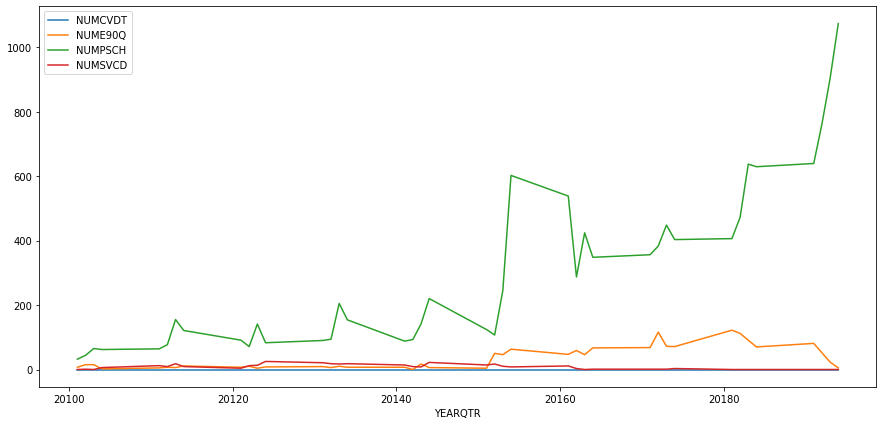

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
my_cd_groups.plot(ax=ax)

How is the number of effluent violations (NUME90Q) related to the number of permit schedule violations (NUMPSCH)?